# Hamiltonian Simulation with Quantum Signal Processing and Qubitization

This tutorial demonstrates how to implement Hamiltonian simulation for block-encoded Hamiltonians using two different techniques: Quantum Singular Eigenvalues Transform (QSVT) and qubitization. It specializes for a [Linear Combination of Unitaries (LCU)](https://github.com/Classiq/classiq-library/blob/main/tutorials/basic_tutorials/quantum_primitives/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb) block-encoding for the Hamiltonian; however, you can  easily modify the implementation of the Hamiltonian simulation to other block-encoding implementations.

The tutorial is organized as follows: 

1. Definitions of block-encoding and the Jacobi–Anger Expansion
2. Definitions of classical and quantum functions that are useful for the Hamiltonian block-encoding
3. Definition of a specific Hamiltonian
4. Implementation of a Hamiltonian simulation using QSVT
5. Implementation of a Hamiltonian simulation using qubitization

The two last sections are independent.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *
from classiq.qmod.symbolic import pi

### Block-Encoding

**Definition**: A $(s, m, \epsilon)$-encoding of a $2^n\times 2^n$ matrix $H$ refers to completing it into a $2^{n+m}\times 2^{n+m}$ unitary matrix $U_{(s,m,\epsilon)-H}$:
$$
U_{(s,m,\epsilon)-H} = \begin{pmatrix}
H/s & * \\
* & *
\end{pmatrix},
$$
with some functional error $\left|\left(U_{(s,m,\epsilon)-H}\right)_{0:2^n-1,0:2^n-1}-H/s \right|\leq \epsilon$. For the most basic use of block-encoding, see the first item in the technical notes at the end of this tutorial.

**Definition**: LCU refers to $(\bar{\alpha}, m, 0)$-block-encoding of a matrix given as a sum of unitaries:
$$
U_{(\bar{\alpha},m,0)-A} =\begin{pmatrix}
A/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } A = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0
$$
with $\bar{\alpha}\equiv\sum^{L-1}_{i=0}\alpha_i$ and $m= \lceil\log_2(L) \rceil$. See the [LCU tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/basic_tutorials/quantum_primitives/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb) for more details.


This tutorial starts with an exact $(s, m, 0)$-encoding of some Hamiltonian and implements an approximated encoding of its Hamiltonian evolution
$$
U_{(\tilde{s},\tilde{m},\epsilon)-\exp{(iHt)}} = \begin{pmatrix}
\exp{(iHt)}/\tilde{s} & * \\
* & *
\end{pmatrix},
$$
using QSVT and qubitization approaches. Both implementations are based on a polynomial approximation of the function $f(x)=e^{ix}$. In particular, perform the block-encoding of $\cos(Ht)$ and $\sin(Ht)$ and then construct an LCU for $e^{iHt}=\cos(Ht)+i\sin(Ht)$. Therefore, the LCU methodology is employed at least twice: once for the block-encoding of $H$, and the second for block-encoding the sum of sine and cosine.



### The Jacobi–Anger Expansion

The Jacobi–Anger expansion approximates the sine and cosine functions with Chebyshev polynomials as follows [[1](#JAwiki)]:
\begin{align}
\cos(xt) &=& J_0(t) + 2\sum^{d}_{k=1} (-1)^k J_{2k}(t) T_{2k}(x)\\
\sin(xt) &=& 2\sum^{d}_{k=0} (-1)^k J_{2k+1}(t) T_{2k+1}(x),
\end{align}
where $J_i(x)$ and $T_i(x)$ are the Bessel function and Chebyshev polynomial of order $i$, respectively, and the degree $d$ is related to the approximation error $\epsilon$ as
$$
d = O\left(t - \frac{\log\epsilon}{1+\log\left(e-\frac{\log(\epsilon)}{t}\right)}\right).
$$

Start with defining a function that gets $\epsilon$ and the evolution time $t$, and returns the Chebyshev coefficients of the sine and cosine functions, using the `scipy` package.

In [2]:
from scipy.special import eval_chebyt, jv


def get_cheb_coef(epsilon, t):
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef

Visualize the approximation for a specific example:

(-0.1, 1.1)

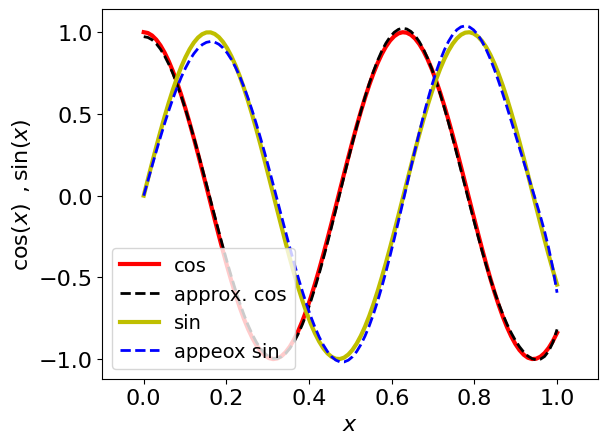

In [3]:
EVOLUTION_TIME = 10
EPS = 0.1

cos_coef, sin_coef = get_cheb_coef(EPS, EVOLUTION_TIME)

xs = np.linspace(0, 1, 100)
approx_cos = sum([cos_coef[k] * eval_chebyt(2 * k, xs) for k in range(len(cos_coef))])
approx_sin = sum(
    [sin_coef[k] * eval_chebyt(2 * k + 1, xs) for k in range(len(sin_coef))]
)
plt.plot(xs, np.cos(EVOLUTION_TIME * xs), "-r", linewidth=3, label="cos")
plt.plot(xs, approx_cos, "--k", linewidth=2, label="approx. cos")
plt.plot(xs, np.sin(EVOLUTION_TIME * xs), "-y", linewidth=3, label="sin")
plt.plot(xs, approx_sin, "--b", linewidth=2, label="appeox sin")
plt.ylabel(r"$\cos(x)\,\,\, , \sin(x)$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc="lower left", fontsize=14)
plt.xlim(-0.1, 1.1)

## Building LCU for Pauli Strings

Focus on Hamiltonians that are given in the Pauli basis, i.e., as a sum of unitaries
$$
H = \sum^{L-1}_{i=0} \alpha_i U_i,
$$
where $U_i$ are Pauli strings. Next, define quantum and classical functions relevant for LCU. 

### Classical Pre-process Functions

The LCU is implemented with the so-called "prepare" and "select" operations. The former prepares a quantum state that corresponds to the probabilities $\alpha_i /\sum\alpha_i$. Define a function that gets the list of $L$ coefficients and returns the coefficients to be loaded as part of the LCU. 

In [4]:
def get_normalized_lcu_coef(unormalized_lcu_coef):
    normalization_factor = sum(np.abs(unormalized_lcu_coef))
    lcu_coef = [c / normalization_factor for c in unormalized_lcu_coef]
    coef_size = int(np.ceil(np.log2(len(lcu_coef))))

    print("The qubit size of the block encoding:", coef_size)
    print("The normalized coefficients:", lcu_coef)
    print("The normalization factor:", normalization_factor)

    return normalization_factor, coef_size, lcu_coef

### Classical Post-process Functions


Working with block-encoding typically requires post-selection of the block variables being at state 0 (see the first technical note at the end of this tutorial). The success of this process can be amplified via a [Quantum Amplitude Amplification](https://github.com/Classiq/classiq-library/blob/main/algorithms/qsvt/qsvt_fixed_point_amplitude_amplification) routine. This issue is beyond the scope of this tutorial, instead, simply work with a statevector simulator. Define a function that gets execution results and returns a projected state vector. 

In [5]:
## fix the execution preferences for this tutorial
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

In [6]:
def get_projected_state_vector(res) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    Expects a 'data' variable, and a 'block' variable to be filtered out when not in the |0> state.
    """
    state_size = 2 ** len(res.output_qubits_map["data"])
    proj_statevector = np.zeros(state_size).astype(complex)

    df = res.dataframe
    # Filter only the successful states.
    filtered_st = df[(df.block == 0) & (np.abs(df.amplitude) > 1e-12)]
    proj_statevector[filtered_st.data] = filtered_st.amplitude
    return proj_statevector

## Taking a Specific Example

For simplicity in the next sections, take a specific Hamiltonian:
$$
H = 0.4 \cdot I\otimes I +0.1\cdot  I\otimes Z + 0.3 \cdot X \otimes X + 0.2\cdot  Z\otimes Z
$$

In [7]:
HAMILTONIAN = (
    0.4 * Pauli.I(0)
    + 0.1 * Pauli.Z(1)
    + 0.05 * Pauli.X(0) * Pauli.X(1)
    + 0.2 * Pauli.Z(0) * Pauli.Z(1)
)

Next, calculate the normalized coefficients for the LCU and the corresponding normalization factor:

In [8]:
lcu_pauli_coef = [p.coefficient for p in HAMILTONIAN.terms]
normalization_ham, lcu_size_ham, lcu_coef_ham = get_normalized_lcu_coef(lcu_pauli_coef)

The qubit size of the block encoding: 2
The normalized coefficients: [0.5333333333333333, 0.13333333333333333, 0.06666666666666667, 0.26666666666666666]
The normalization factor: 0.75


### Verifying the Hamiltonian Block-encoding

Before moving to the more complex Hamiltonian simulation implementation, it is useful to verify the Hamiltonian block-encoding. For this, define a model in which to apply $U_H$ on some random vector state of size $2^n\cdot 2^m$, $(\vec{b},\vec{0})$, and verify that the resulting state, after post-selection, gives $(H/\bar{\alpha})\vec{b}$.

For the LCU - use the `lcu_pauli` function from the classiq library.

In [9]:
DATA_SIZE = HAMILTONIAN.num_qubits
b = np.random.rand(2**DATA_SIZE)
b = (b / np.linalg.norm(b)).tolist()

In [10]:
@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    allocate(lcu_size_ham, block)
    prepare_amplitudes(b, 0.0, data)
    lcu_pauli(HAMILTONIAN, data, block)


qprog_1 = synthesize(main)
show(qprog_1)

Quantum program link: https://platform.classiq.io/circuit/33dX4iGaWiY5uVSTl4zVZbzNkT5


In [11]:
with ExecutionSession(qprog_1, execution_preferences=execution_preferences) as es:
    res_1 = es.sample()

Use the predefined function for the post-selection:

In [12]:
state_result_1 = get_projected_state_vector(res_1)

To compare to the expected result, get the matrix in the standard basis:

In [13]:
matrix = pauli_operator_to_matrix(HAMILTONIAN)

The quantum state that returns from execution is given up to some global phase. To compare to the expected state, run these lines:

In [14]:
expected_state_1 = matrix / normalization_ham @ b
relative_phase = np.angle(expected_state_1[0] / state_result_1[0])
state_result_1 = state_result_1 * np.exp(1j * relative_phase)

In [15]:
print("The resulting state:", np.real(state_result_1))
print("The expected state:", np.real(expected_state_1))
assert np.allclose(state_result_1, expected_state_1)

The resulting state: [0.44344585 0.31014328 0.11966078 0.04754157]
The expected state: [0.44344585 0.31014328 0.11966078 0.04754157]


## Hamiltonian Simulation with Qubitization

Given the block-encoding $U_{(s,m,0)-H}$, define the following operator (usually called the Szegedy quantum walk operator [[5](#Szegedy)]):
$$
W\equiv -\Pi_{|0\rangle_m} U_{(s,m,0)-H},
$$  
where $\Pi_{|0\rangle_m}$ is a reflection operator about the block state. This unitary function has the important property that its powers correspond to a $(1,m,0)$-encoding of the Chebyshev polynomials:
$$
W^k = \begin{pmatrix}
T_k(H) & * \\
* & *
\end{pmatrix}=U_{(1,m,0)-T_k(H)},
$$
with $T_k$ being the k-th Chebyshev polynomial. For more details, see Sec. 7 in Ref. [[2](#Qubitization)]. (The property holds only for Hermitian block-encoding. For generalization, see comment 3 below.) You can thus simply combine the Jacobi–Anger expansion with the LCU technique to get the block-encoding for the Hamiltonian simulation. Namely, you have an $\epsilon$-approximation of $\exp(iHt)\approx \sum^d_{i=0} \beta_{i} T_{i}(x)$, for which you can perform the following encoding:
$$
U_{(\bar{\beta},\tilde{m},\epsilon)-\exp{(iHt)}} =
\begin{pmatrix}
\exp{(iHt)}/\bar{\beta} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} U_{(1,m,0)-T_k(H)} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} T_{k}(Ht) & * \\
* & *
\end{pmatrix}
=\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} W^k & * \\
* & *
\end{pmatrix},
$$
where $\tilde{m}=m+\lceil \log_2(d+1) \rceil$ (recalling that $W$ are block-encodings themselves, with block size $m$).

Define a walk operator for this specific example. For the reflection, use the `reflect_about_zero` quantum function from the Classiq open library.

In [16]:
@qfunc
def my_walk_operator(data: QArray, block: QArray) -> None:
    lcu_pauli(HAMILTONIAN, data, block)
    reflect_about_zero(block)
    RY(2 * pi, block[0])  # for the minus sign

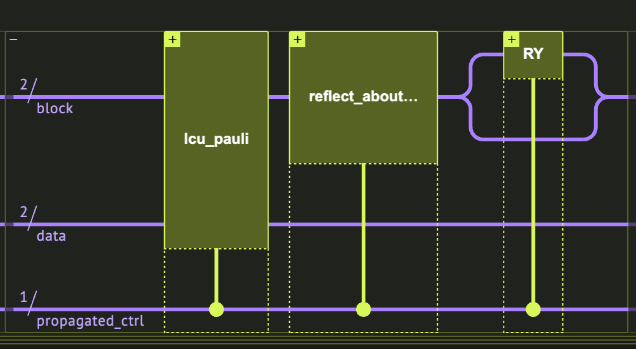

Next, use the predefined function to calculate the coefficients $\beta_i$ for approximating the sine and cosine functions. Recall that you want to approximate $e^{iHt}$, whereas the Hamiltonian is encoded with a normalization factor $\bar{\alpha}$. Therefore, you must rescale the time by this factor.

In [17]:
from itertools import zip_longest

normalized_time = normalization_ham * EVOLUTION_TIME
cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)

combined_sin_cos_coef = []
for c, s in zip_longest(cos_coef, sin_coef):
    if c is not None:
        combined_sin_cos_coef.append(c)
    if s is not None:
        combined_sin_cos_coef.append(s)

For the odd terms, which correspond to the sine function, add a factor of $i$ to the unitary operations $W^k$. 

In [18]:
cheb_coefs = [x * 1j if i % 2 == 1 else x for i, x in enumerate(combined_sin_cos_coef)]

normalization_exp, lcu_size_exp, normalized_coef_exp = get_normalized_lcu_coef(
    cheb_coefs
)

The qubit size of the block encoding: 4
The normalized coefficients: [0.06646302105481754, 0.06750041778530919j, 0.11492593070021927, 0.1287942474920928j, 0.011890532706545037, 0.14147748237907418j, -0.17674611046555386, (-0-0.141316294365812j), 0.08704430568396189, 0.044378224426640044j, -0.0194634329399742]
The normalization factor: 4.007336014122894


Define a quantum function for a generic LCU of Chebyshev polynomials, which gets the lcu coefficients and a walk operator as a quantum callable. Use the `lcu` function from the classiq library.

In [19]:
cheb_coefs

[0.2663396578803785,
 0.270496855159411j,
 0.4605468210515807,
 0.5161218263869207j,
 0.0476493599420441,
 0.5669478103251011j,
 -0.7082810538247574,
 (-0-0.5663018757945106j),
 0.34881578099166266,
 0.17783845698770298j,
 -0.07799651577882445]

In [58]:
from classiq.open_library.functions.state_preparation import apply_phase_table


@qfunc
def lcu_cheb(
    coefs: list[float],
    walk_operator: QCallable,
    cheb_block: QArray,
):
    coefs = coefs + [0] * (2**cheb_block.len - len(coefs))
    magnitudes = [np.abs(c) for c in coefs]
    magnitudes = (np.array(magnitudes) / np.sum(magnitudes)).tolist()
    phases = [np.angle(complex(c)) for c in coefs]
    within_apply(
        lambda: inplace_prepare_state(magnitudes, 0.0, cheb_block),
        lambda: (
            repeat(
                cheb_block.len,
                lambda i: control(
                    cheb_block[i], lambda: power(2**i, lambda: walk_operator())
                ),
            ),
            apply_phase_table(phases, cheb_block),
        ),
    )
    # lcu(
    #     coef,
    #     [lambda k=k: power(k, lambda: walk_operator()) for k in range(coef.len)],
    #     cheb_block,
    # )

The code in the rest of this section builds a model that applies the `lcu_cheb` function on the randomly prepared vector $(\vec{b},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results. 

In [59]:
@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    ham_block = QNum()
    exp_block = QNum()

    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)

    prepare_amplitudes(b, 0.0, data)
    lcu_cheb(
        normalized_coef_exp,
        lambda: my_walk_operator(data, ham_block),
        exp_block,
    )
    bind([ham_block, exp_block], block)


write_qmod(
    main,
    "hamiltonian_simulation_qubitization",
    decimal_precision=12,
    symbolic_only=False,
)

Synthesize the quantum model and execute it:

In [60]:
qprog_2 = synthesize(main, preferences=Preferences(optimization_level=1))
# show(qprog_2)

In [61]:
with ExecutionSession(qprog_2, execution_preferences) as es:
    results_2 = es.sample()

state_result_2 = get_projected_state_vector(results_2)

In [62]:
expected_state_2 = (
    1 / normalization_exp * scipy.linalg.expm(1j * matrix * EVOLUTION_TIME) @ b
)
relative_phase = np.angle(expected_state_2[0] / state_result_2[0])
state_result_2 = state_result_2 * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state_2)
print("resulting state:", state_result_2)
assert np.linalg.norm(state_result_2 - expected_state_2) < EPS

expected state: [ 0.07684157+0.07910265j -0.20634931-0.01248152j  0.01393571+0.07314088j
  0.01444284+0.04026547j]
resulting state: [ 0.07574951+0.07797847j -0.20712937-0.01094978j  0.01168453+0.07189256j
  0.01345094+0.04056151j]


In [63]:
print(
    "overlap between expected and resulting state:",
    np.abs(np.vdot(state_result_2, expected_state_2))
    * normalization_exp
    / np.linalg.norm(state_result_2),
)

overlap between expected and resulting state: 0.999899726721946


***


## Hamiltonian Simulation with QSVT

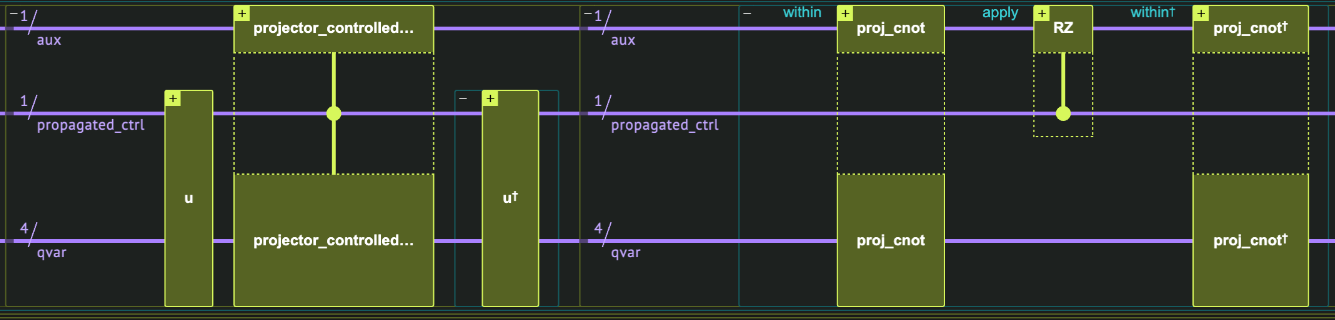

The QSVT is a general technique for applying block-encoding of matrix polynomials via quantum signal processing. Refer to Ref. [[3](#grand)] and the [QSVT notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/qsvt/qsvt_matrix_inversion/qsvt_matrix_inversion.ipynb) for more information about this generic and important subject. For the QSVT approach, repeatedly apply two operations:  $U_H$ application and rotated reflections around the block space, applied on an extra qubit. The value of the rotation angles is found using the `pyqsp` package. 

The QSVT gives block-encoding of polynomials with a well defined parity. Thus, you apply two QSVT blocks—one for approximating the $\cos(xt)$ function and one for the $\sin(xt)$ function—and then, for the finale, construct an LCU to get the block-encoding of the sum $e^{ixt} = \cos(xt)+i\sin(xt)$. For a realization of such a model on real hardware, see Ref. [[4](#paper)].

Start by calculating the rotation angles for the sine and cosine polynomial approximations. As for the qubitization method, normalize the evolution time $t$. In addition, the `pysqp` adds a factor $1/2$ to the sine and cosine polynomials.

In [26]:
import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

pg_cos = pyqsp.poly.PolyCosineTX()
pcoefs_cos, scale_cos = pg_cos.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True, chebyshev_basis=True
)

pg_sin = pyqsp.poly.PolySineTX()
pcoefs_sin, scale_sin = pg_sin.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True, chebyshev_basis=True
)

12.104183283573647
R=6
[PolyCosineTX] rescaling by 0.5.
12.104183283573647
R=6
[PolySineTX] rescaling by 0.5.


In [27]:
ang_seq_cos = QuantumSignalProcessingPhases(
    pcoefs_cos,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)

ang_seq_sin = QuantumSignalProcessingPhases(
    pcoefs_sin,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)


# change W(x) to R(x), as the phases are in the W(x) conventions see Eq.()
def convert_phases_to_Rx_convention(ang_seq):
    phases = np.array(ang_seq)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    phases = -2 * phases

    return phases.tolist()

The list of angles to use within the `qsvt` function are given by

In [28]:
phases_cos = convert_phases_to_Rx_convention(ang_seq_cos)
phases_sin = convert_phases_to_Rx_convention(ang_seq_sin)

Next, use the [Classiq `qsvt` function](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qsvt/qsvt.ipynb) to get the QSVT of the sine and cosine block-encoding. This open library function has the following arguments:
- `phases`: the series of rotations according to quantum signal processing
-  `proj_cnot_1`, `proj_cnot_2`: the projection operations for the block space. In this case, these are identical, defined below as the `identify_block`
- `u`: the block-encoding quantum function—the `lcu_paulis` function
- `qvar`: the combined variables of the block-encoding function
- `qsvt_aux`: the extra qubit for the QSVT rotations

Define a QSVT function for the specific Hamiltonian and approximation. Passing it the `phases_cos` or `phases_sin` series of angles generates the block-encodings:
$$
U_{(2,m+1,\epsilon)-\cos(Ht)} = \begin{pmatrix}
\cos(iHt)/2 & * \\
* & *
\end{pmatrix}, \,\,\,\,\,\,
U_{(2,m+1,\epsilon)-\sin(Ht)} = \begin{pmatrix}
\sin(iHt)/2 & * \\
* & *
\end{pmatrix}
$$  
where the extra qubit and factor $1/2$ in the encoding comes from the QSVT.


In [29]:
class BlockEncodedState(QStruct):
    data: QNum[DATA_SIZE, False, 0]
    block: QNum[lcu_size_ham, False, 0]


@qfunc
def identify_block(state: BlockEncodedState, qubit: QBit):
    qubit ^= state.block == 0


@qfunc
def block_encode_hamiltonian(state: BlockEncodedState):
    lcu_pauli(
        HAMILTONIAN,
        state.data,
        state.block,
    )


# defining a qsvt for the specific example
@qfunc
def my_qsvt(phases: CArray[CReal], qsvt_aux: QBit, state: BlockEncodedState):
    qsvt(
        phase_seq=phases,
        proj_cnot_1=identify_block,
        proj_cnot_2=identify_block,
        u=block_encode_hamiltonian,
        qvar=state,
        aux=qsvt_aux,
    )

Finally, to get the desired Hamiltonian simulation, apply an LCU with the two unitaries: 
$$
U_{(2,m+1,\epsilon)-\cos(Ht)} + iU_{(2,m+1,\epsilon)-\sin(Ht)}.
$$
The normalized LCU coefficients are therefore $(1/2,1/2)$, giving an $(4, m+2,\epsilon)$-encoding for the Hamiltonian simulation:
$$
U_{((4, m+2,\epsilon))-\exp{(iHt)}} = \begin{pmatrix}
\frac{1}{4}\exp{(iHt)} & * \\
* & *
\end{pmatrix}.
$$

The code in the rest of this section builds a model that applies this block-encoding on the randomly prepared $(\vec{b},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results.

In [30]:
@qfunc
def main(data: Output[QNum[DATA_SIZE]], block: Output[QNum]):
    qsvt_aux = QBit()
    block_exp = QBit()
    state = BlockEncodedState()

    allocate(qsvt_aux)
    allocate(block_exp)
    allocate(state)

    inplace_prepare_amplitudes(b, 0.0, state.data)

    lcu(
        [0.5, 0.5j],
        [
            lambda: my_qsvt(phases_cos, qsvt_aux, state),  # cosine
            lambda: my_qsvt(phases_sin, qsvt_aux, state),
        ],  # sine
        block_exp,
    )

    bind([state, qsvt_aux, block_exp], [data, block])


write_qmod(
    main, "hamiltonian_simulation_qsvt", decimal_precision=12, symbolic_only=False
)

In [31]:
qprog_3 = synthesize(main)
show(qprog_3)

Quantum program link: https://platform.classiq.io/circuit/32pVRcKI4IjroBOuEocmlUDI6xf


In [32]:
with ExecutionSession(qprog_3, execution_preferences) as es:
    results_3 = es.sample()

state_result_3 = get_projected_state_vector(results_3)

In [33]:
expected_state_3 = 1 / 4 * scipy.linalg.expm(1j * matrix * EVOLUTION_TIME) @ b
relative_phase = np.angle(expected_state_3[0] / state_result_3[0])
state_result_3 = state_result_3 * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state_3)
print("resulting state:", state_result_3)
assert np.linalg.norm(state_result_3 - expected_state_3) < EPS

expected state: [ 0.12320702+0.15632021j -0.08414137-0.02009688j  0.05989139+0.09211906j
  0.04214705-0.03938393j]
resulting state: [ 0.1231618 +0.15626283j -0.08420219-0.0200773j   0.05990688+0.09207412j
  0.04217423-0.03937266j]


In [34]:
print(
    "overlap between expected and resulting state:",
    np.abs(np.vdot(state_result_3, expected_state_3))
    * 4
    / np.linalg.norm(state_result_3),
)

overlap between expected and resulting state: 0.9999999228507099


## Technical Notes

1. Basic use of the block-encoding unitary: Let's say you have a $(s, m, 0)$-encoding of a matrix $A$
$$
U_{(s, m, 0)-A} = \begin{pmatrix}
	 A/s & *  \\
	 * & * 
\end{pmatrix},
$$
where the dimension of $A$ is $2^n\times 2^n$.
If you apply this unitary on the state 
$$
|\psi\rangle_n|0\rangle_m =|\psi\rangle_n \otimes 
\begin{pmatrix}
	 1  \\
      0\\
	 \vdots \\
  0
\end{pmatrix} =  
\begin{pmatrix}
	 |\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix},
$$
you  get
$$
U_{(s, m, 0)-A} \left(|\psi\rangle_n|0\rangle_m \right)  = 
\begin{pmatrix}
	 \frac{1}{s}A|\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix}
+
\begin{pmatrix}
	 0  \\
      *\\
	 \vdots \\
  *
\end{pmatrix} = \frac{1}{s}A|\psi\rangle_n|0\rangle_m +\sum_{l\neq 0} c_l |\phi\rangle_n|l\rangle_m .
$$
Thus, if you measure $|0\rangle_m$ on the second variable, you know the first variable is the state $\frac{1}{s}A|\psi\rangle_n$. In terms of measurement, post-select on $|0\rangle_m$ to measure the desired state. You can amplify the success of this operation, given by $|\frac{1}{s}A|\psi\rangle_n|$, with Quantum Amplitude Amplification.


2. Generalization to Pauli strings with non-positive coefficients: The assumption that all the coefficients $\alpha_i$ in the Hamiltonian decomposition to Pauli strings are positive can be easily relaxed by entering non-positive or complex coefficients into the definition of $U_i$. Thus, you can modify `get_cheb_coef` to return the "generalized signs" and add phases to the Pauli strings accordingly, as in the qubitization method above.

3. Generalization to non-Hermitian block-encoding: This tutorial took a Hermitian Hamiltonian block-encoding; that is, the unitary $U_{(s,m,0)-H}$ itself is Hermitian. In the case of non-Hermitian unitary block-encoding, the cited property of the walk operator $W$ does not hold. However, a similar property holds for $\tilde{W}\equiv U_{(s,m,0)-H}^T\Pi_{|0\rangle_m} U_{(s,m,0)-H}\Pi_{|0\rangle_m}$. (See Sec. 7.4 in Ref. [[2](#qubitization)].)

<a id='JAwiki'>[1]</a>: [Jacobi-Anger Expansion](https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion).

<a id='qubitization'>[2]</a>: [Lin, L. "Lecture notes on quantum algorithms for scientific computation
." arXiv:2201.08309 \[quant-ph\])](https://arxiv.org/abs/2201.08309).

<a id='grand'>[3]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. "Grand unification of quantum algorithms." PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)

<a id='paper'>[4]</a>: [Kikuchi, Y, Mc Keever, C, Coopmans, L, et al. "Realization of quantum signal processing on a noisy quantum computer". npj Quantum Inf 9, 93 (2023)](https://www.nature.com/articles/s41534-023-00762-0).

<a id='Szegedy'>[5]</a>: [M. Szegedy, "Quantum speed-up of Markov chain based algorithms," In 45th Annual IEEE symposium on foundations of computer science, pages 32–41, 2004](https://ieeexplore.ieee.org/abstract/document/1366222).
